# Pocket EVALUATION
Evaluate the finetuned model using the pocket-wise metric: DCC.


## Activate venv
`source ~/cryptic-nn/src/fine-tuning/esmc-venv/bin/activate`

# Define model
Define the finetuning model.

In [1]:
### PREDICTION SOURCE CODE ###

import torch
from transformers import AutoTokenizer, EsmModel
import numpy as np
import torch.nn as nn
import os
import sys
sys.path.append('/home/skrhakv/cryptic-nn/src')
import finetuning_utils

torch.manual_seed(420)

ESM_MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_SIZE = 1
DROPOUT = 0.25

MODEL_PATH = "/home/skrhakv/cryptic-nn/final-data/trained-models/multitask-finetuned-model-with-ligysis.pt"
DECISION_THRESHOLD = 0.7  # Threshold to consider a point as high score; see src/decision-thresholds.ipynb (https://github.com/skrhakv/cryptic-finetuning)
VERBOSE_OUTPUT = False  

class FinetuneESM(nn.Module):
    def __init__(self, esm_model: str) -> None:
        super().__init__()
        self.llm = EsmModel.from_pretrained(esm_model)
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE)
        self.plDDT_regressor = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE)
        self.distance_regressor = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE)

    def forward(self, batch: dict[str, np.ndarray]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        input_ids, attention_mask = batch["input_ids"], batch["attention_mask"]
        token_embeddings = self.llm(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        return (
            self.classifier(token_embeddings),
            self.plDDT_regressor(token_embeddings),
            self.distance_regressor(token_embeddings),
        )

model = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
tokenizer = AutoTokenizer.from_pretrained(ESM_MODEL_NAME)


### Load
Loading the smoothing classifier model.

In [2]:
sys.path.append('/home/skrhakv/cryptoshow-analysis/src/B-evaluate-cryptoshow')
import eval_utils
from eval_utils import CryptoBenchClassifier

SMOOTHING_MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/smoother.pt'
smoothing_model = torch.load(SMOOTHING_MODEL_PATH, weights_only=False)

### Compute
Predict the sequence, cluster the predictions and smoothen it.

In [5]:
# this is clustering agglomerative clustering (with PCAed embeddings and estimation of active clusters using GMM) + smoothing 
import sys
sys.path.append('/home/skrhakv/cryptoshow-analysis/src/B-evaluate-cryptoshow')
import eval_utils

PRECALCULATED = False
PRECALCULATED_PATH = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/predictions/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'
FINETUNED_EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/embeddings'
PRECALCULATED_EMBEDDINGS_DIR = '/home/skrhakv/cryptic-nn/data/cryptobench/embeddings'
cryptic_binding_residues, sequences = eval_utils.read_test_binding_residues()


predicted_binding_sites = {}
prediction_scores = {}
for protein_id in sequences.keys():
    print(f'Processing {protein_id}...')
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{FINETUNED_EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)
    clusters = eval_utils.compute_clusters(
        coordinates,
        prediction,
    decision_threshold=0.5,
        method='dbscan', # method='pca+gmm+agglomerative',
        embeddings_path=f'{PRECALCULATED_EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    )

    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    predicted_binding_sites[protein_id] = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 
        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        predicted_binding_sites[protein_id].append((enhanced_residue_indices, 'finetuned model with smoothing'))

import pickle
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/predictions'

for protein_id in sequences.keys():
    filename = protein_id.replace('_','')
    with open(f'{PREDICTIONS_PATH}/PCA,GMM,AgglomerativeClust,thenSmoothing-finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
        pickle.dump(predicted_binding_sites[protein_id], f)

# import numpy as np
# for protein_id in prediction_scores.keys():
#     np.save(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy', prediction_scores[protein_id])

Processing 7qoq_A...
Processing 8i84_B...
Processing 5igh_A...
Processing 7w19_A...
Processing 5uxa_A...
Processing 3h8a_B...
Processing 6isu_A...
Processing 5yhb_A...
Processing 3rwv_A...
Processing 2i3a_D...
Processing 4oqo_B...
Processing 3gdg_B...
Processing 1kx9_A...
Processing 1kxr_A...
Processing 1ute_A...
Processing 7f4y_B...
Processing 7nlx_A...
Processing 1se8_A...
Processing 7xgf_E...
Processing 5yj2_C...
Processing 7e5q_B...
Processing 5e0v_A...
Processing 6jq9_B...
Processing 7o1i_A...
Processing 3ly8_A...
Processing 1bzj_A...
Processing 7c63_A...
Processing 7x0i_B...
Processing 5ysb_B...
Processing 3k01_A...
Processing 5kcg_B...
Processing 8b9p_A...
Processing 3bjp_A...
Processing 4uc8_A...
Processing 5b0e_B...
Processing 5yqp_A...
Processing 1nd7_A...
Processing 4fkm_B...
Processing 2phz_A...
Processing 3mwg_B...
Processing 2vl2_C...
Processing 6bty_B...
Processing 2fhz_B...
Processing 5caz_A...
Processing 3n4u_A...
Processing 6fc2_C...
Processing 4hye_A...
Processing 1i

### Residue-level stats
Take the predictions from the previous steps and calculate residue-level metrics: F1, MCC, ACC.

In [4]:
# actual = []
# predicted = []
# 
# from sklearn import metrics
# for protein_id in cryptic_binding_residues.keys():
#     this_actual = np.zeros(len(sequences[protein_id]), dtype=int)
#     for binding_site in cryptic_binding_residues[protein_id]:
#         binding_site = [int(i.split('_')[1]) for i in binding_site]
#         this_actual[binding_site] = 1
#     this_predicted = np.zeros(len(sequences[protein_id]), dtype=int)
#     for binding_site in predicted_binding_sites[protein_id]:
#         this_predicted[binding_site] = 1
#     predicted.append(this_predicted)
#     actual.append(this_actual)
# 
# labels = np.concatenate(actual)
# predictions = np.concatenate(predicted)
# 
# acc = metrics.accuracy_score(labels, predictions)
# mcc = metrics.matthews_corrcoef(labels, predictions)
# f1 = metrics.f1_score(labels, predictions, average='weighted')
# 
# print(f'ACC: {acc}, MCC: {mcc}, F1: {f1}')
print('0.9285945654129926 0.455878939471634 0.9278459044017294')

0.9285945654129926 0.455878939471634 0.9278459044017294


### No clustering/smoothing
Only predict using the sequence, without any clustering or smoothing. However, use the same evaluation pipeline.

In [5]:
# no_clustering_predicted = []
# for protein_id in sequences.keys():
#     pdb_id = protein_id[:4]
#     sequence = sequences[protein_id]
#     embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
#     
#     prediction = compute_prediction(
#         sequence,
#         embeddings_path
#     )
#     this_predicted = (prediction > DECISION_THRESHOLD).astype(int)
#     no_clustering_predicted.append(this_predicted)
# predictions = np.concatenate(no_clustering_predicted)
# 
# acc = metrics.accuracy_score(labels, predictions)
# mcc = metrics.matthews_corrcoef(labels, predictions)
# f1 = metrics.f1_score(labels, predictions, average='weighted')
# 
# print(f'ACC: {acc}, MCC: {mcc}, F1: {f1}')
# print('Results are different than in the paper "Hidden in protein sequences: Predicting cryptic binding sites" because the test set is slightly different - the binding residues were completed by LIGYSIS')
print('ACC: 0.9319596904804751, MCC: 0.4961393895010758, F1: 0.9322347096744608 Results are different than in the paper "Hidden in protein sequences: Predicting cryptic binding sites" because the test set is slightly different - the binding residues were completed by LIGYSIS')

ACC: 0.9319596904804751, MCC: 0.4961393895010758, F1: 0.9322347096744608 Results are different than in the paper "Hidden in protein sequences: Predicting cryptic binding sites" because the test set is slightly different - the binding residues were completed by LIGYSIS


### Pocket-level stats
Compute DCC.

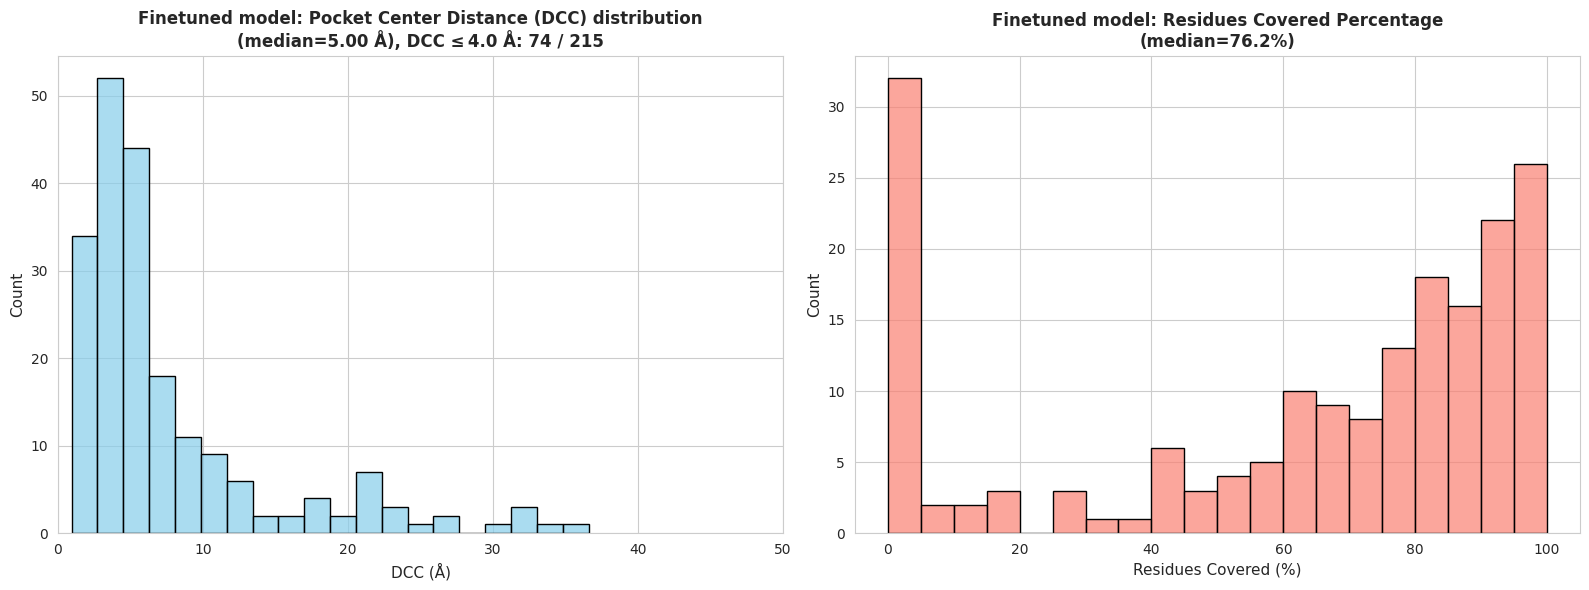

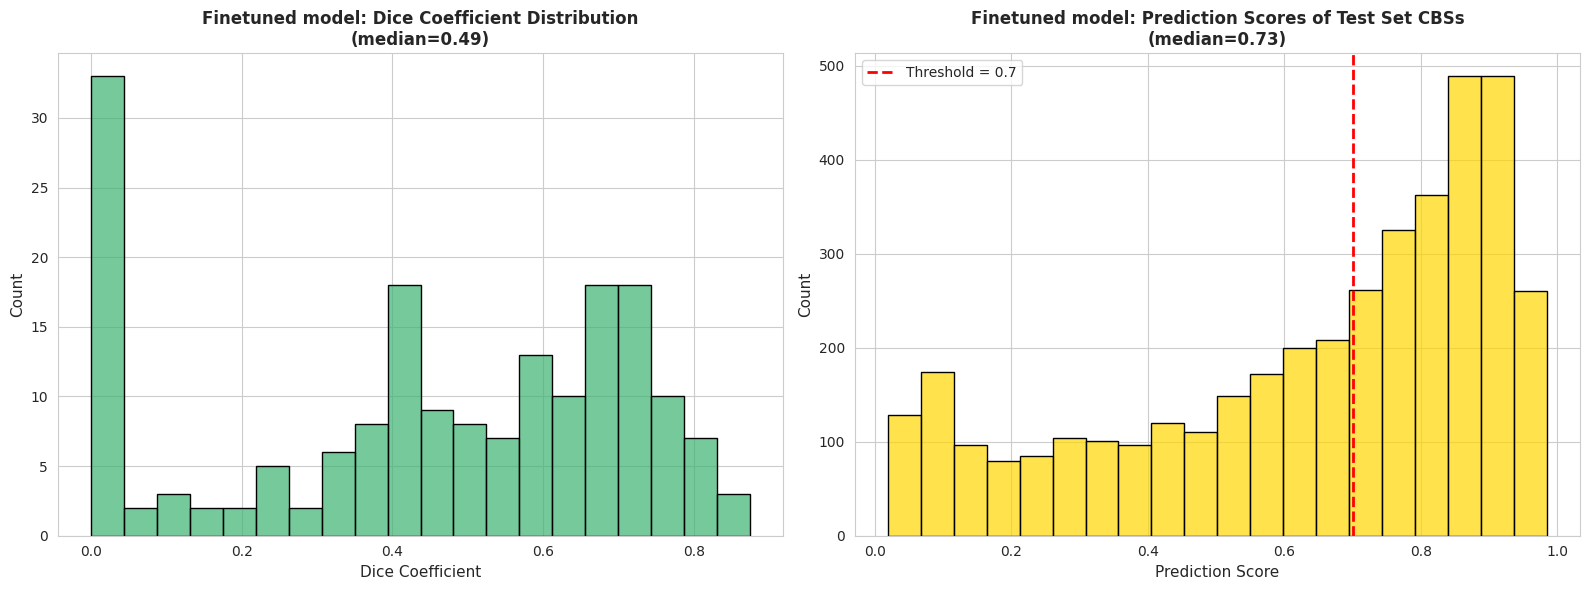

In [6]:
## This is with clustering (PCA+GMM+Agglomerative) and smoothing
MODEL = 'Finetuned model'

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(cryptic_binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)

In [12]:
# this is GMM clustering + smoothing + additional agglomerative clustering (with PCAed embeddings and estimation of active clusters using GMM)


import sys

from sklearn.mixture import BayesianGaussianMixture
sys.path.append('/home/skrhakv/cryptoshow-analysis/src/B-evaluate-cryptoshow')
import eval_utils

PRECALCULATED = True
PRECALCULATED_PATH = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/predictions/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'
FINETUNED_EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/embeddings'
PRECALCULATED_EMBEDDINGS_DIR = '/home/skrhakv/cryptic-nn/data/cryptobench/embeddings'
cryptic_binding_residues, sequences = eval_utils.read_test_binding_residues()



def remap_clusters(labels, coords):
    from scipy.spatial.distance import cdist
    from scipy.sparse.csgraph import connected_components

    centers = []
    for label in np.unique(labels):
        cluster_residues = np.where(labels == label)[0]
        centers.append(np.mean(coords[cluster_residues], axis=0))

    # 2. Define your merging threshold (in Angstroms)
    # 12-15 Angstroms is usually a good size for a binding pocket radius
    MERGE_THRESHOLD = 18.0 

    # 3. Calculate distance between all cluster centers
    # specific shape: (n_clusters, n_clusters)
    distances = cdist(centers, centers)

    # 4. Create an adjacency matrix (True if close, False if far)
    # This creates a "graph" where clusters are nodes and closeness is an edge
    adjacency_matrix = distances < MERGE_THRESHOLD

    # 5. Find connected components (groups of clusters to merge)
    # n_merged: total number of new super-clusters
    # new_mapping: array where index is old label, value is new label
    n_merged, new_mapping = connected_components(adjacency_matrix, directed=False)

    # 6. Apply the new mapping to your data points
    final_labels = new_mapping[labels]
    return final_labels




predicted_binding_sites = {}
prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{FINETUNED_EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    precalculated_embedding_path = f'{PRECALCULATED_EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)
    clusters = eval_utils.compute_clusters(
        coordinates,
        prediction,
        method='gmm',
    )

    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    predicted_binding_sites[protein_id] = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 
        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        predicted_binding_sites[protein_id].append((enhanced_residue_indices, 'finetuned model with smoothing'))

    if len(predicted_binding_sites[protein_id]) == 0:
        continue
    
    merged_binding_sites = np.concatenate([i for i, _ in predicted_binding_sites[protein_id]])
    embeddings = np.load(precalculated_embedding_path)

    binding_site_coords = coordinates[merged_binding_sites]
    binding_site_embeddings = embeddings[merged_binding_sites]

    from sklearn.decomposition import PCA

    pca = PCA(n_components=min(5, binding_site_embeddings.shape[0]), random_state=42)
    projections = pca.fit_transform(binding_site_embeddings)

    concatenated_features =  np.concatenate((projections, binding_site_coords), axis=1)

    bgmm = BayesianGaussianMixture(
        n_components=len(concatenated_features), 
        random_state=42,
        covariance_type='spherical',
        weight_concentration_prior=1e-15,
    )   

    bgmm.fit(concatenated_features)    

    active_clusters = sum(bgmm.weights_ > 0.1)

    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=max(active_clusters, 1), linkage='single')

    labels = clustering.fit_predict(concatenated_features)
    labels = remap_clusters(labels, binding_site_coords)

    predicted_binding_sites[protein_id] = []
    for cluster_label in np.unique(labels):
        if cluster_label == -1:
            continue
        cluster_residue_indices = merged_binding_sites[np.where(labels == cluster_label)[0]]
        predicted_binding_sites[protein_id].append((cluster_residue_indices, 'finetuned model with smoothing and reclustering'))

import pickle
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/predictions'

for protein_id in sequences.keys():
    filename = protein_id.replace('_','')
    with open(f'{PREDICTIONS_PATH}/GMMspherical,smoothing,PCA,GMM,AgglomerativeClust-finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
        pickle.dump(predicted_binding_sites[protein_id], f)
# import numpy as np
# for protein_id in prediction_scores.keys():
#     np.save(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy', prediction_scores[protein_id])

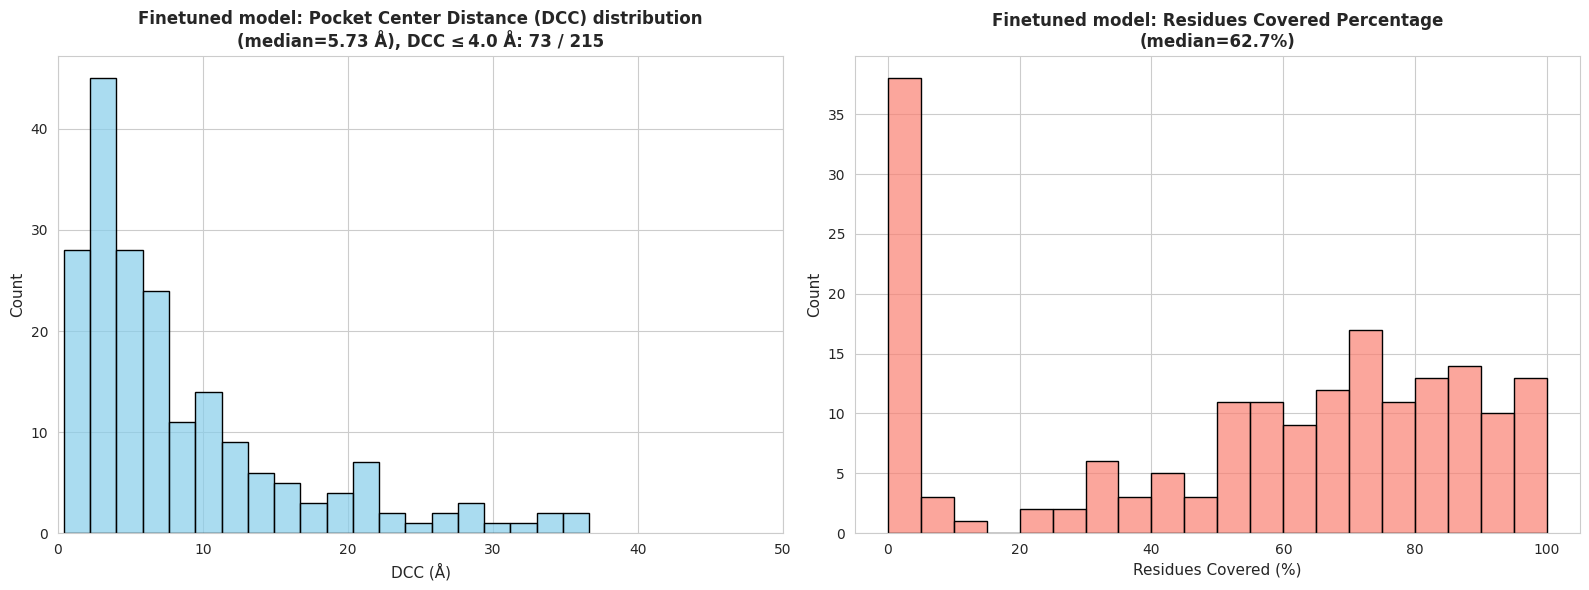

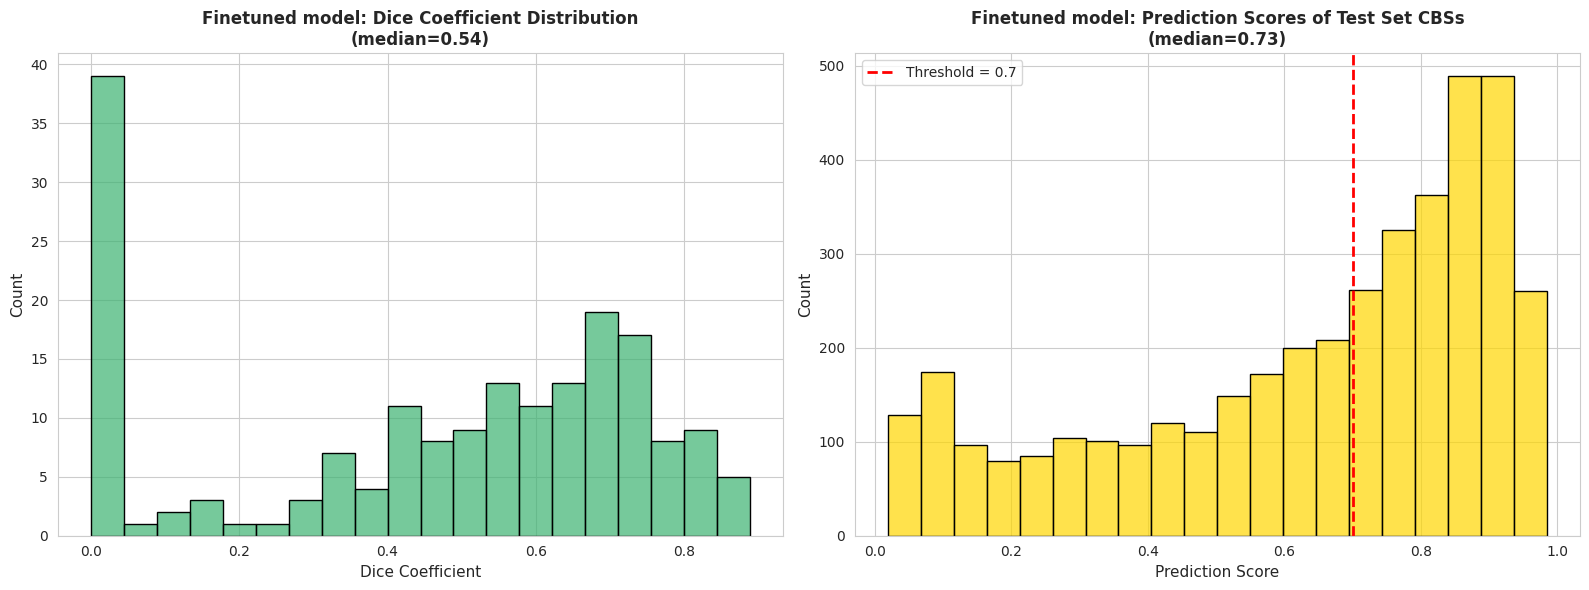

In [11]:
MODEL = 'Finetuned model'

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(cryptic_binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)

In [7]:
import pickle
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/predictions'

for protein_id in sequences.keys():
    filename = protein_id.replace('_','')
    with open(f'{PREDICTIONS_PATH}/GMMfull,postprocessing-finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
        pickle.dump(predicted_binding_sites[protein_id], f)

## Combine predictions
Take predictions of p2rank and finetuned model, and combine them. Plot the results to see, whether the predictions are complementary or not.

In [7]:
import pickle
cryptic_binding_residues, sequences = eval_utils.read_test_binding_residues()

with open('/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/predicted_pockets_p2rank.pkl', 'rb') as f:
    p2rank_predictions = pickle.load(f)
    # reformat in order to have the same format as predicted_binding_sites - dictionary of numpy arrays
    p2rank_predictions = {key:[np.array([int(ii[1:]) for ii in i]) for i in predicted_pockets] for key, predicted_pockets in p2rank_predictions.items()}

def merge_predictions(predicted_binding_sites: dict[str, list[tuple[np.ndarray, str]]], p2rank_predictions: dict[str, list[np.ndarray]]):
    """
    Merge the predicted binding sites from the finetuned model and p2rank.

    Args:
        predicted_binding_sites (dict): Dictionary where keys are protein IDs and values are lists of tuples (binding_site_indices, 'finetuned model with smoothing').
        p2rank_predictions (dict): Dictionary where keys are protein IDs and values are lists of numpy arrays of binding site indices predicted by p2rank.

    Returns:
        dict: Merged dictionary with keys as protein IDs and values as lists of tuples (binding_site_indices, source).
    """
    merged_predictions = {}
    for protein_id in sequences.keys():
        merged_predictions[protein_id] = []
        # add finetuned model predictions
        for binding_sites in predicted_binding_sites[protein_id]:
            merged_predictions[protein_id].append(binding_sites)
        # add p2rank predictions
        for binding_sites in p2rank_predictions[protein_id]:
            merged_predictions[protein_id].append((binding_sites, 'p2rank'))
    return merged_predictions
merged_predictions = merge_predictions(predicted_binding_sites, p2rank_predictions)

In [ ]:
import pickle
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/predictions'

for protein_id in sequences.keys():
    filename = protein_id.replace('_','')

#    with open(f'{PREDICTIONS_PATH}/finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
#        pickle.dump(predicted_binding_sites[protein_id], f)
#    with open(f'{PREDICTIONS_PATH}/p2rank/{filename}.pkl', 'wb') as f:
#        pickle.dump(p2rank_predictions[protein_id], f)

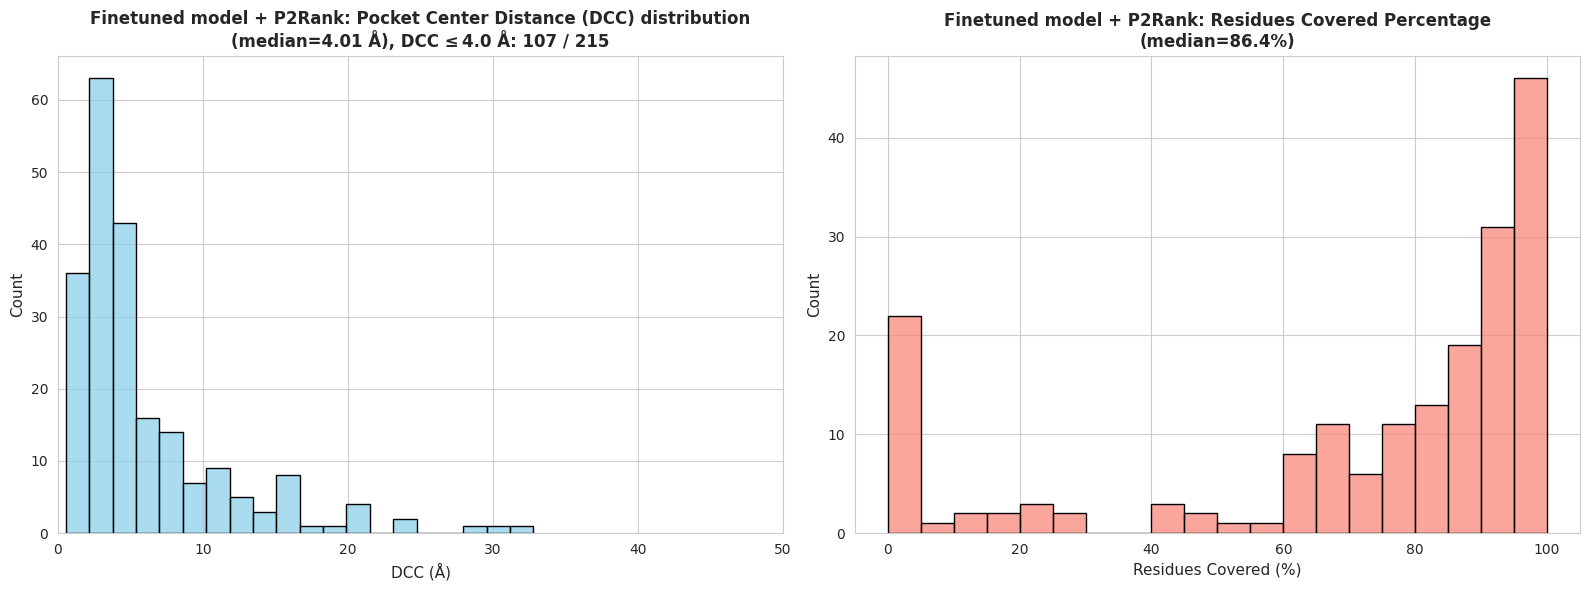

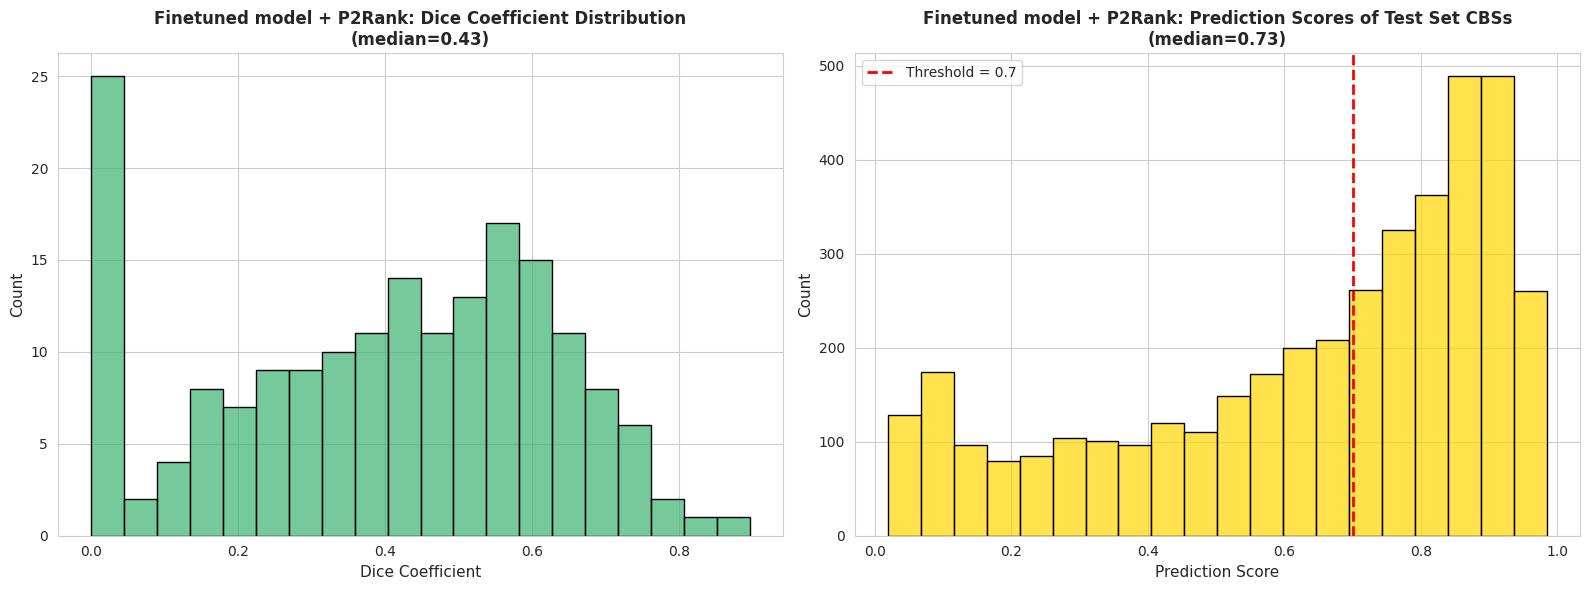

In [8]:
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(cryptic_binding_residues, merged_predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)

MODEL = 'Finetuned model + P2Rank'
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)

### Dice coefficient distribution - explanation of value drop
The dice coefficient distribution median value drops for the merged results when compared to single finetuned model. The equation is following:
```
dice_coefficient = 2 * len(intersection) / (len(cryptic_binding_residues) + len(predicted_binding_residues))
```
That is resulted by the including of the P2Rank, as it predicts more pockets out of the true positives than the finetuned model. Therefore, it results in increasing in `len(predicted_binding_residues)`, and, therefore, decreases the values of `dice_coefficient`.

# No smoothing
Run finetuned model without smoothing. Also, do the merge with P2Rank and compare.

In [13]:
import sys

from sklearn.cluster import DBSCAN
sys.path.append('/home/skrhakv/cryptoshow-analysis/src/B-evaluate-cryptoshow')
import eval_utils

COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'
EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/embeddings'
cryptic_binding_residues, sequences = eval_utils.read_test_binding_residues()

no_smoothing_predicted_binding_sites = {}
no_smoothing_prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    
    if not PRECALCULATED or protein_id not in prediction_scores:
        # finetuned prediction
        prediction = compute_prediction(
        sequence,
        embeddings_path
        )
    elif protein_id in prediction_scores:
        # load precalculated prediction
        prediction = prediction_scores[protein_id]
    elif PRECALCULATED:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')

    predicted_indices = np.where(prediction > DECISION_THRESHOLD)[0]

    # compute clusters without smoothing
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'
    coordinates = np.load(coordinates_path)

    high_score_points = coordinates[predicted_indices]  # Extract only (x, y, z) coordinates

    EPS = 5.0  # Max distance for neighbors
    MIN_SAMPLES = 3  # Min points to form a cluster

    # No pockets can be formed if there are not enough high score points.
    if len(high_score_points) < MIN_SAMPLES:
        no_smoothing_predicted_binding_sites[protein_id] = []
        no_smoothing_predicted_binding_sites[protein_id].append((predicted_indices, 'finetuned model without smoothing'))
        no_smoothing_prediction_scores[protein_id] = prediction
        continue
    
    dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
    labels = dbscan.fit_predict(high_score_points)

    # Initialize all labels to -1
    clusters = -1 * np.ones(len(prediction), dtype=int)
    # Assign cluster labels to high score points
    clusters[predicted_indices] = labels
    clusters_indices = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_indices = np.where(clusters == cluster_label)[0]
        clusters_indices.append(cluster_indices)

    no_smoothing_prediction_scores[protein_id] = prediction
    no_smoothing_predicted_binding_sites[protein_id] = [(i, 'finetuned model without smoothing') for i in clusters_indices]

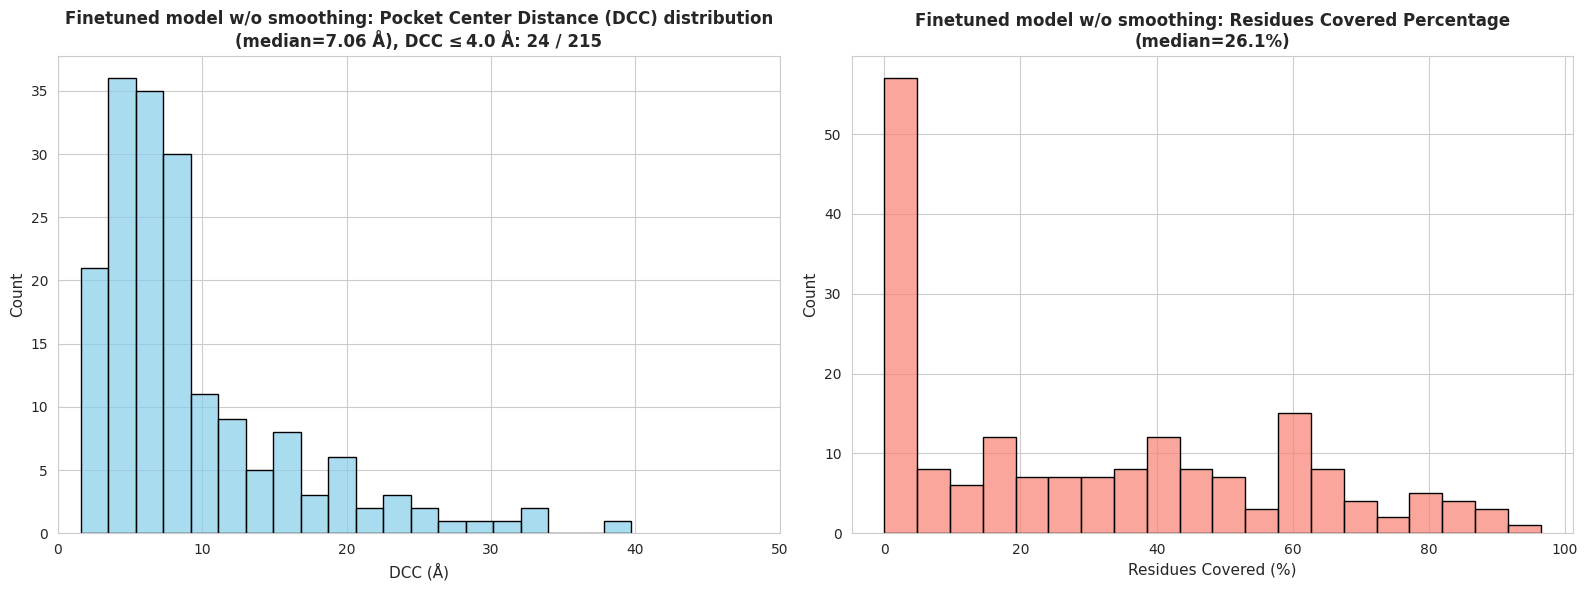

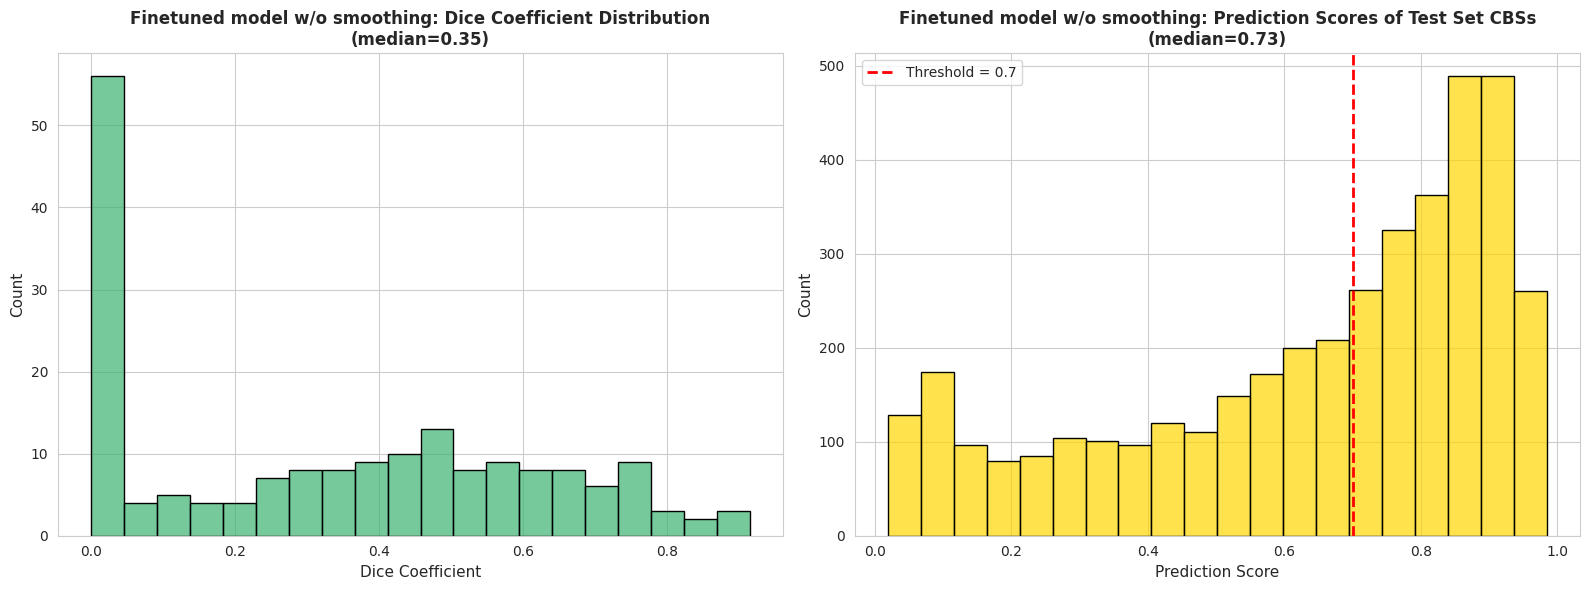

In [14]:
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(cryptic_binding_residues, no_smoothing_predicted_binding_sites, no_smoothing_prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
MODEL = 'Finetuned model w/o smoothing'

eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)

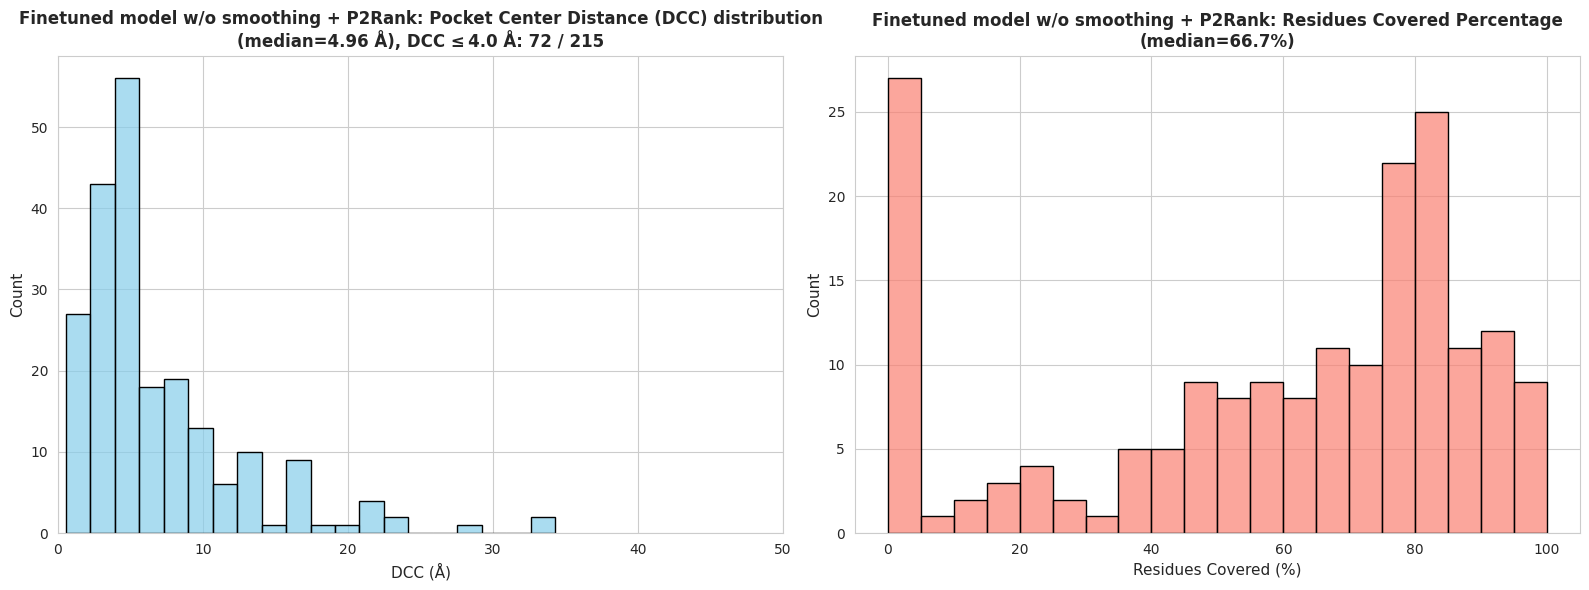

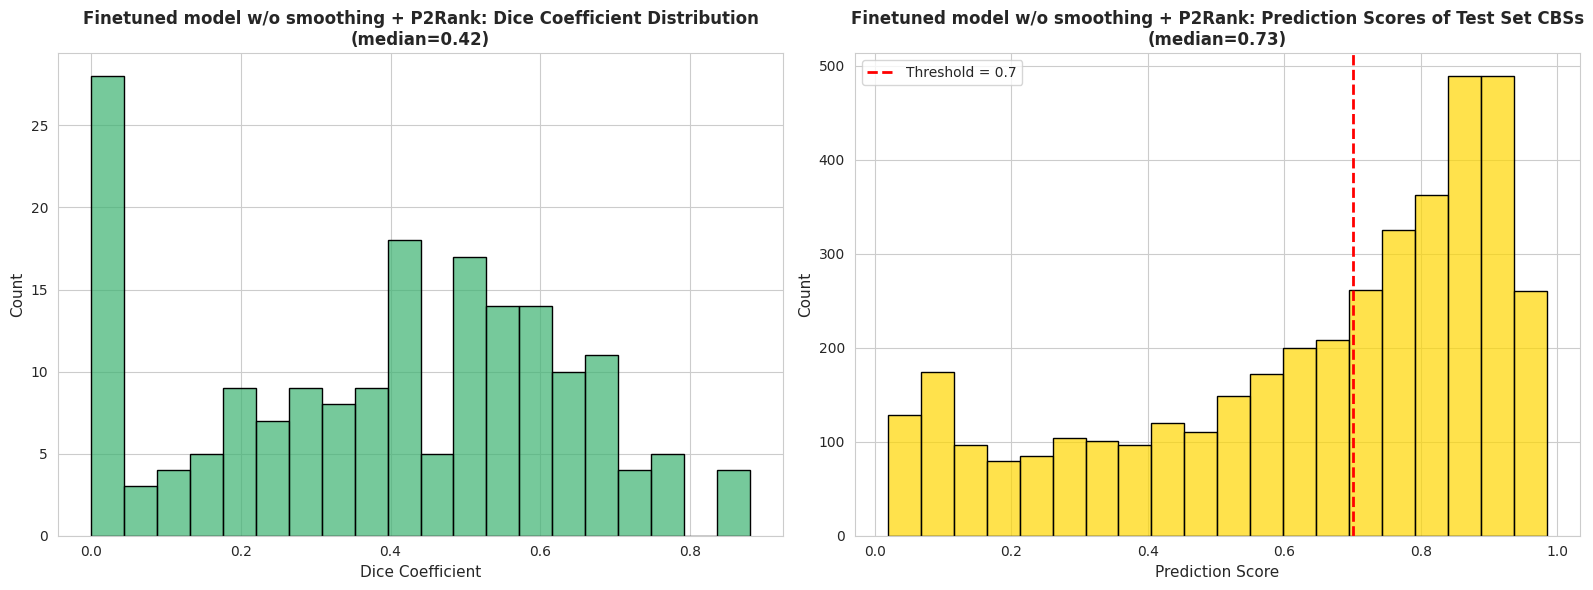

In [15]:
import pickle
cryptic_binding_residues, sequences = eval_utils.read_test_binding_residues()

with open('/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/predicted_pockets_p2rank.pkl', 'rb') as f:
    p2rank_predictions = pickle.load(f)
    # reformat in order to have the same format as predicted_binding_sites - dictionary of numpy arrays
    p2rank_predictions = {key:[np.array([int(ii[1:]) for ii in i]) for i in predicted_pockets] for key, predicted_pockets in p2rank_predictions.items()}

no_smoothing_merged_predictions = {}
for protein_id in sequences.keys():
    no_smoothing_merged_predictions[protein_id] = []
    # add finetuned model predictions
    for binding_sites in no_smoothing_predicted_binding_sites[protein_id]:
        no_smoothing_merged_predictions[protein_id].append(binding_sites)
    # add p2rank predictions
    for binding_sites in p2rank_predictions[protein_id]:
        no_smoothing_merged_predictions[protein_id].append((binding_sites, 'p2rank'))

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(cryptic_binding_residues, no_smoothing_merged_predictions, no_smoothing_prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
MODEL = 'Finetuned model w/o smoothing + P2Rank'

eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)

# TODO:
1. evaluate on non_cryptic pockets
2. evaluate on non_cryptic+cryptic pockets

# NON_CRYPTIC pockets
Run the whole pipeline again. This time on non-cryptic pockets.

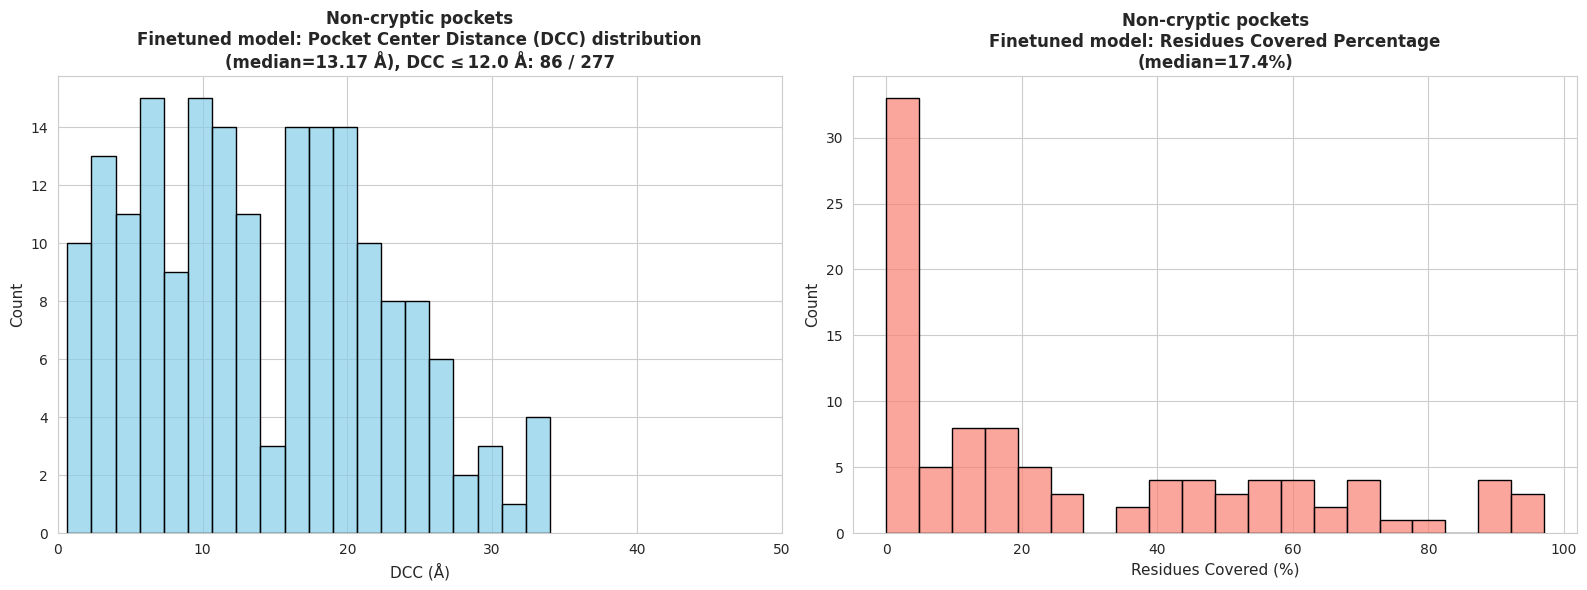

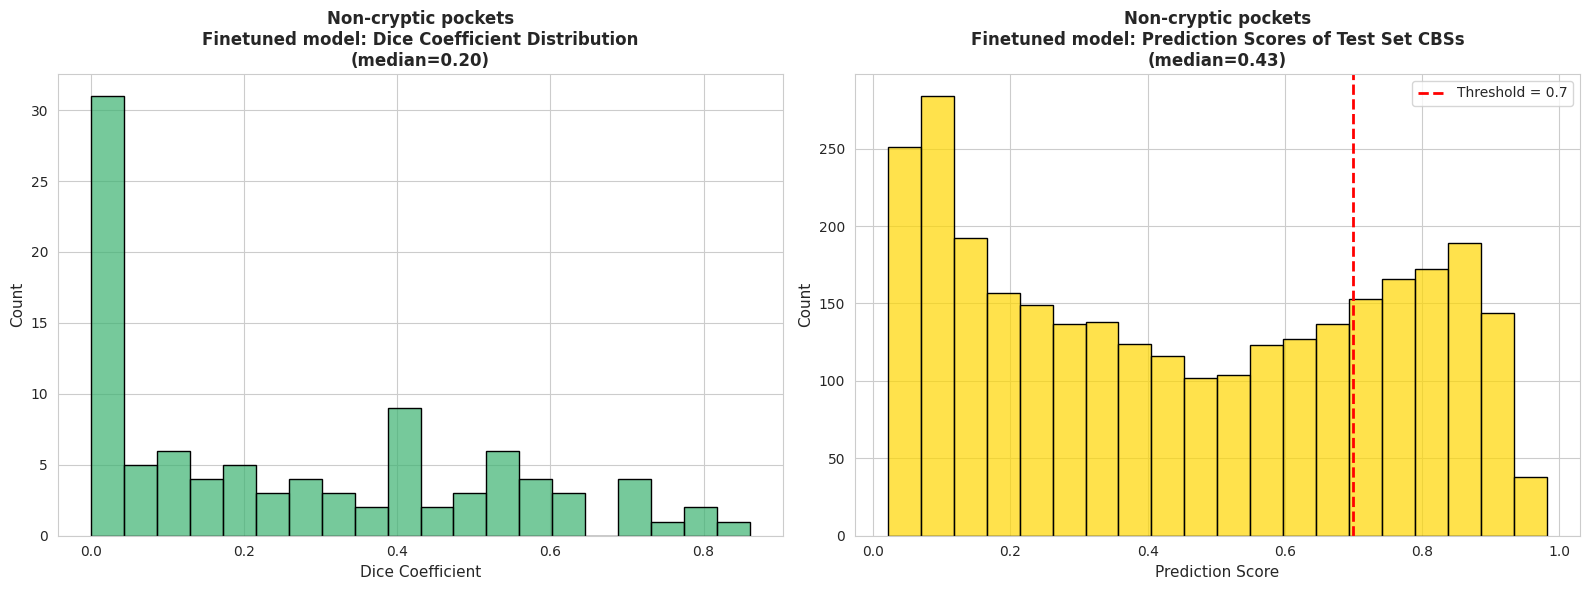

In [5]:
MODEL = 'Non-cryptic pockets\nFinetuned model'

non_cryptic_binding_residues, sequences = eval_utils.read_test_binding_residues(pocket_types=['NON_CRYPTIC'])
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(non_cryptic_binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)

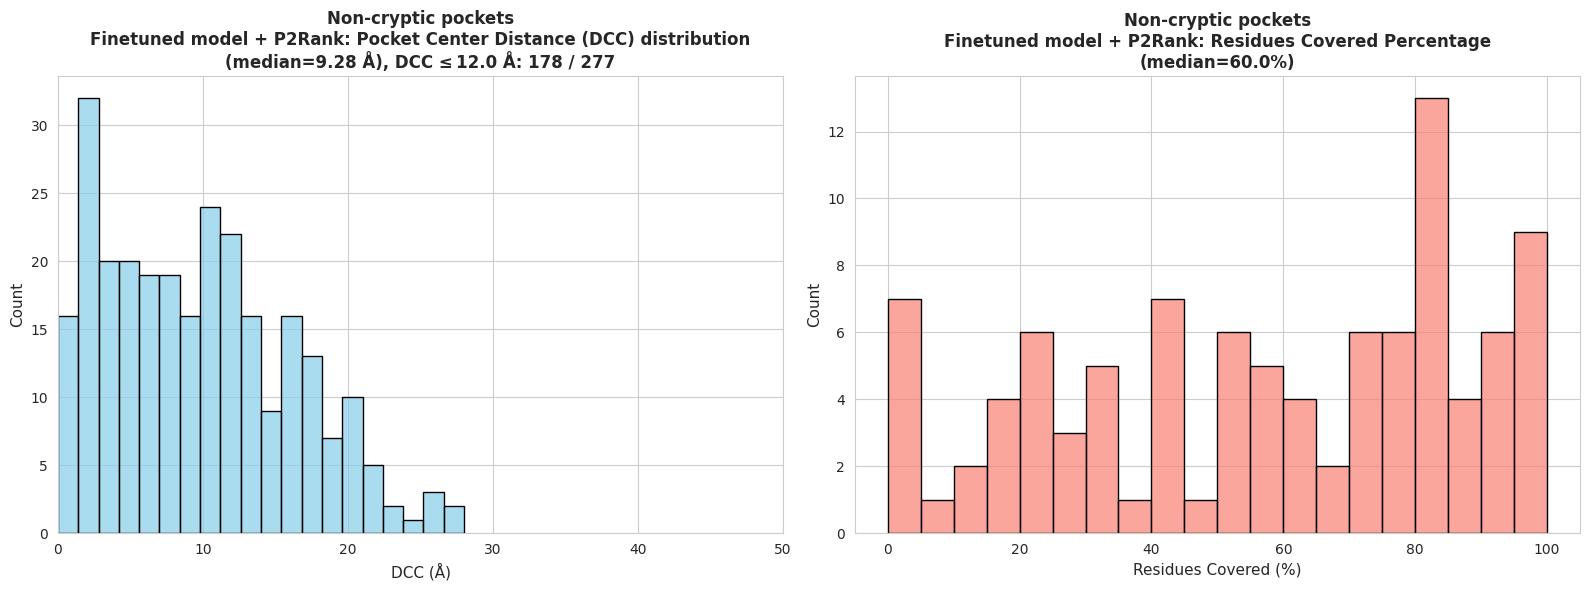

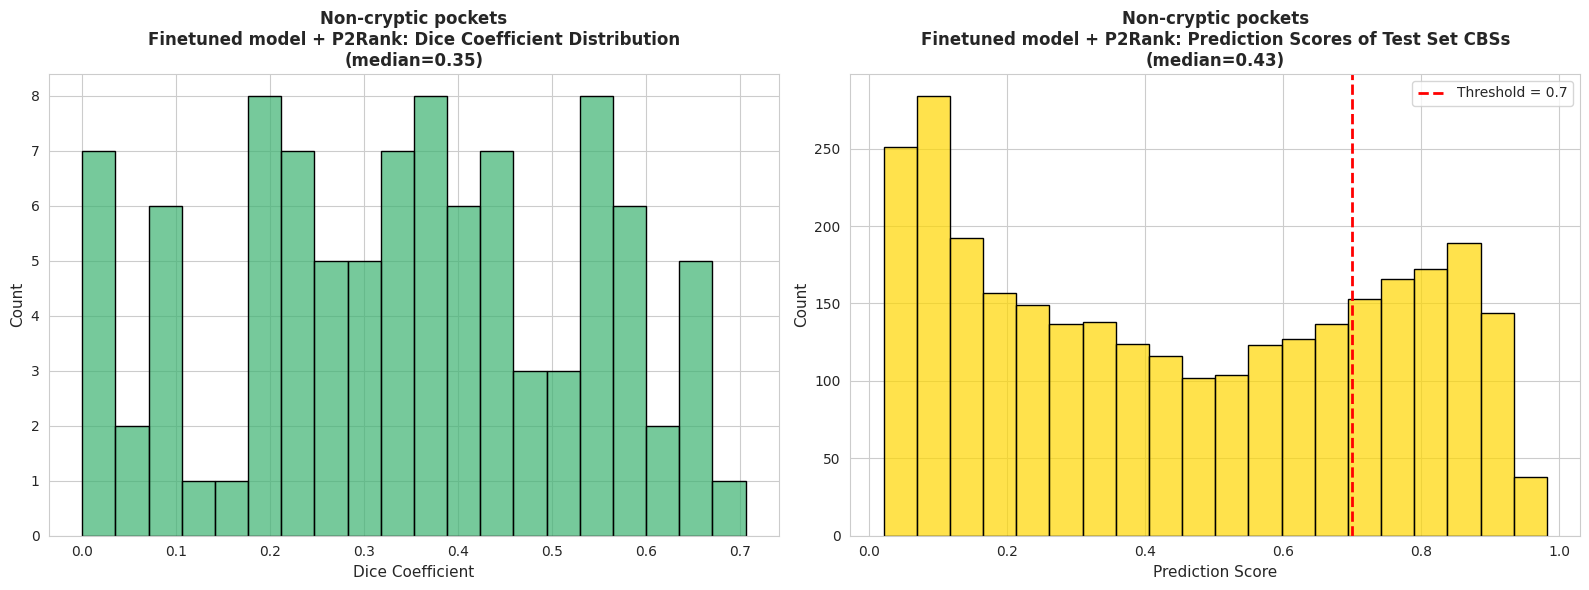

In [8]:
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(non_cryptic_binding_residues, merged_predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)

MODEL = 'Non-cryptic pockets\nFinetuned model + P2Rank'
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)